# Notebook to explore group differences

In [1]:
from nfact_id.functions.modelling_fuc import get_zscores_distrubtions, get_zscore_summary, get_meaningful_values, is_meaningful, reshape_posteriors, subject_meaningul_components
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import xarray as xr
import arviz as az
from decouple import config
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os
import numpy as np
from scipy.stats import norm
import bambi as bmb
import os
os.environ["CPATH"] = "/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1"

## Get dataframe

In [2]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "hcp")
storage_dir = os.path.join(config("base_dir"), "group_tests")
beh_dir = config("behavioural")

In [3]:
G_patients = pd.read_csv(os.path.join(storage_dir, "grey_ppc.csv"))
W_patients = pd.read_csv(os.path.join(storage_dir, "white_ppc.csv"))

## Get Demographics data

In [4]:
ep_data = pd.read_excel(os.path.join(beh_dir, "behavioural", "EP", "DemographicFiles.xlsx"))
banda_data = pd.read_excel(os.path.join(beh_dir, "behavioural", "BANDA", "DemographicFiles.xlsx"))
banda_data = banda_data.drop_duplicates(subset=["src_subject_id"], keep='last')
pdc_data = pd.read_excel(os.path.join(beh_dir, "behavioural", "PDC", "DemographicFiles.xlsx"))
pdc_data['src_subject_id'] = pdc_data['src_subject_id'].apply(lambda x: x.replace("_", ""))

In [5]:
behav_data_set = pd.concat([ep_data[['src_subject_id', 'interview_age', 'sex', 'race']][1:].reset_index(drop=True), 
                            banda_data[['src_subject_id', 'interview_age', 'sex', 'race']][1:].reset_index(drop=True),
                            pdc_data[['src_subject_id', 'interview_age', 'sex', 'race']][1:].reset_index(drop=True)]
)
behav_data_set = behav_data_set[behav_data_set['src_subject_id'].isin(W_patients['subject'].unique())]
behav_data_set['interview_age'] = behav_data_set['interview_age'].astype("int")


## Load the models

In [6]:
idata_ctrl_white = az.from_netcdf(os.path.join(storage_dir, "normative_WM_fitted.nc"))
idata_ctrl_grey = az.from_netcdf(os.path.join(storage_dir, "normative_GM_fitted.nc"))

## Calculate z score distrubtions


$$
z_{ij} = \frac{y_{i,j} - \hat{y}_{i,j}}{\sqrt{\sigma^2_{i,j} + \sigma^2_{j,n}}}
$$
$$

i = 0, \dots, n_{\text{component}}, \quad
j = 1, \dots, n_{\text{subject}} \\
n = \text{the normative distubtion}      \\
$$
<p style="text-align:center;"><em>(see Marquand et al., 2016)</em></p>

In [7]:
g_zscores = get_zscores_distrubtions(idata_ctrl_grey, G_patients['value'].to_numpy())
w_zscores = get_zscores_distrubtions(idata_ctrl_white, W_patients['value'].to_numpy())

## Get z score summaries

In [8]:
w_summary = get_zscore_summary(w_zscores)
g_summary = get_zscore_summary(g_zscores)

## Reshape posterior samples to be more informative

In [9]:
wm_posteriors = reshape_posteriors(w_zscores, W_patients['subject'].unique().shape[0], W_patients['component_num'].unique().shape[0] )
gm_posteriors = reshape_posteriors(g_zscores, G_patients['subject'].unique().shape[0], G_patients['component_num'].unique().shape[0] )

## Create dataframes with summary stats by group and component type

In [10]:
w_scores = pd.concat([W_patients.reset_index(drop=True), w_summary.reset_index(drop=True)], axis=1)
g_scores = pd.concat([G_patients.reset_index(drop=True), g_summary.reset_index(drop=True)], axis=1)

## Group differences

The approach is two fold. 
1) Overall Summation measure. The Idea is can component loadings be summed into a single meteric and is that meaningful
2) Do individual components differ by group?

For all group analysis a ROPE of 0.1 (effect size was picked based on Friston et al., 2002)



## Summation

The analysis plan for this is:

1) Find the number of patients that meet the follow criteria:
    - mean of distubtion > 0.1 (or having an effect greater than a cohen's d of 0.1)
    - The log posterior probiablity of 95% of distubtion outside ROPE (Masharipov et al., 2021)
2) Get the mean HDI confidence intervals for the controls
3) Do this process across all patients, sub groups and white/grey matter


$$
\begin{gather}
\Theta_j = \sum_{i=1}^{n_\text{components}} \theta_{ij} \quad \\
\mathbb{E}[\Theta_j] > 0.1 \\
\log \Pr(\Theta_j \notin \text{ROPE}) = \log 0.95 \\
\text{ROPE}_j = \big[ \text{HDI}_{2.5\%}(\overline{\Theta}_{\text{HC},j}), \; \text{HDI}_{97.5\%}(\overline{\Theta}_{\text{HC},j}) \big], \quad
\overline{\Theta}_{\text{HC},j} = \frac{1}{n_{\text{HC}}} \sum_{s=1}^{n_{\text{HC}}} \Theta_{s,j}, \quad
\end{gather}
$$

### Make the long df wide

This is to make sure that the the subjects data mateches the reshaped posteriors


In [11]:
w_data_wide = w_scores.pivot(
    index=['subject', 'group'],   
    columns='component_num',     
    values=['mean'],
).reset_index().sort_values(by='group').reset_index(drop=True)
w_data_wide.columns = [f"{comp} {comp_num}".rstrip() for comp , comp_num in w_data_wide.columns]

In [12]:
g_data_wide = g_scores.pivot(
    index=['subject', 'group'],   
    columns='component_num',     
    values=['mean'],
).reset_index().sort_values(by='group').reset_index(drop=True)
g_data_wide.columns = [f"{comp} {comp_num}".rstrip() for comp , comp_num in g_data_wide.columns]

### Organise behavioural data by how the models where trained

In [13]:
beh_data = pd.merge(left=w_data_wide, right=behav_data_set, left_on="subject", right_on="src_subject_id")[['subject', 'group', 'interview_age', 'sex', 'race']]

### Get the posteriors for each subjects summation statistic
This is done my all patients and controls

In [14]:
w_all = wm_posteriors.mean("comp")
g_all = gm_posteriors.mean("comp")
w_subjects_sum = w_all[w_data_wide[~w_data_wide['group'].str.contains("Control")].index]
g_subjects_sum = g_all[g_data_wide[~g_data_wide['group'].str.contains("Control")].index]
w_controls_sum = w_all[w_data_wide[w_data_wide['group'].str.contains("Control")].index]
g_controls_sum = g_all[g_data_wide[g_data_wide['group'].str.contains("Control")].index]

### Get the summary for the controls

This is just to get the mean HDI to use as ROPE

In [15]:
white_sum = az.summary(w_controls_sum, hdi_prob=0.95)
grey_sum = az.summary(g_controls_sum, hdi_prob=0.95)

### Now get the HDI means

In [16]:
g_rope = [grey_sum["hdi_2.5%"].mean(), grey_sum["hdi_97.5%"].mean()]
w_rope = [white_sum["hdi_2.5%"].mean(), white_sum["hdi_97.5%"].mean()]

### Get the number of subjects with a meaningful difference 




In [17]:
w_meaningful = is_meaningful(w_subjects_sum, rope=(w_rope[0], w_rope[1]))
g_meaningful = is_meaningful(g_subjects_sum, rope=(g_rope[0], g_rope[1]))

#### Get the posterior distrubtion of patients with meaning differences

In [18]:
w_meaningful_patients = w_subjects_sum[w_meaningful].mean(dim="sub")
g_meaningful_patients = g_subjects_sum[g_meaningful].mean(dim="sub")

### Calculate the percentage of patients with a meaningful difference

In [19]:
patient_numbers = w_data_wide[~w_data_wide['group'].str.contains("Control")].shape[0]

percentage_affected = {
        "White Matter": round((len(w_meaningful)/patient_numbers) * 100, 2),
        "Grey Matter": round((len(g_meaningful)/patient_numbers) * 100, 2)
}


### Plot the efect sizes across all patients and meaningful patients

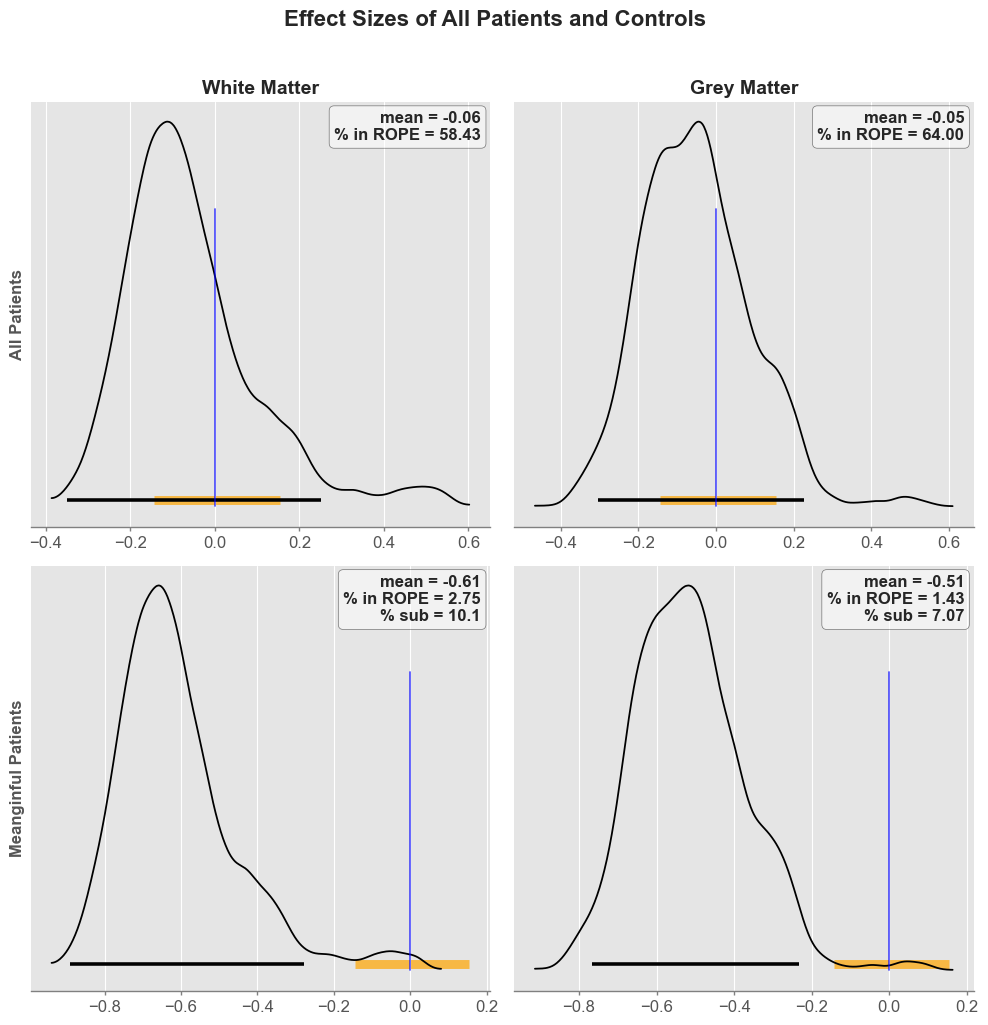

In [32]:
# Data and labels
data_sets = [
    (w_subjects_sum.mean(dim="sub"), g_subjects_sum.mean(dim="sub"), "All Patients"),
    (w_meaningful_patients, g_meaningful_patients, "Meanginful Patients"),
]

col_titles = ["White Matter", "Grey Matter"]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for row, (w_data, g_data, row_title) in enumerate(data_sets):
    for col, (data, ctitle) in enumerate(zip([w_data, g_data], col_titles)):
        if col_titles == "White Matter":
            rope = w_rope
        else:
            rope = g_rope
        ax = axes[row, col]
        az.plot_posterior(
            data,
            hdi_prob=0.95,
            ref_val=0,
            rope=rope,
            ax=ax,
            textsize=12,
            color="black",
            rope_color="orange",
            ref_val_color="blue",
        )
        # Clear default title
        ax.set_title("")

        # Add column titles only in the first row
        if row == 0:
            ax.set_title(ctitle, fontsize=14, fontweight="bold")

        # Add row titles on left side
        if col == 0:
            ax.set_ylabel(row_title, fontsize=12, fontweight="bold")

        # Remove ArviZ default text (mean/HDI)
        for txt in list(ax.texts):
            txt.remove()

        mean_val = data.mean().item()
        rope_pct = 100 * ((data > rope[0]) & (data < rope[1])).mean().item()
        

        # Add annotation box
        box_text = (
            f"mean = {mean_val:.2f}\n"
            f"% in ROPE = {rope_pct:.2f}"
            
        )
        if row_title == "Meanginful Patients":
            perc_effect = percentage_affected[ctitle]
            box_text = box_text + (f"\n% sub = {perc_effect}")
        ax.text(
            0.98,
            0.98,
            box_text,
            transform=ax.transAxes,
            ha="right",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.5,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ),
        )
fig.suptitle("Effect Sizes of All Patients and Controls", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


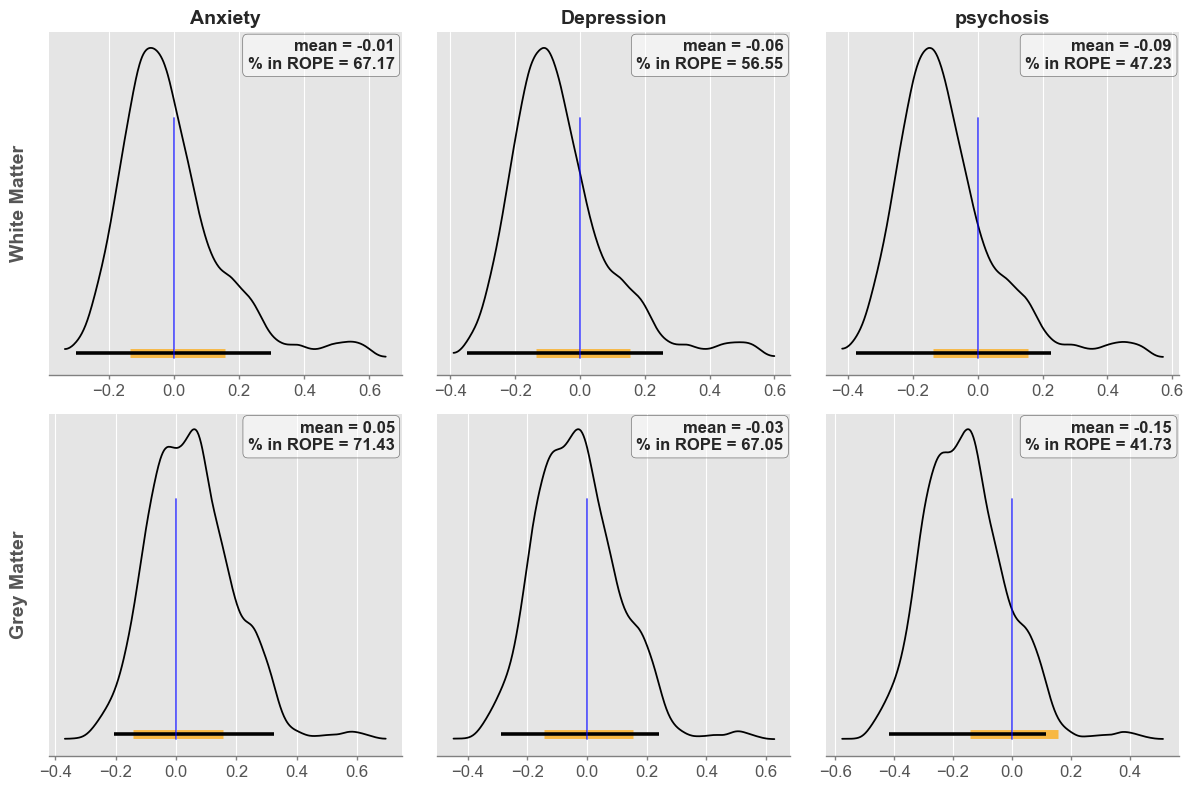

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))


groups = ["Anxiety", "Depression", "psychosis"]
datasets = [w_all, g_all]
row_labels = ["White Matter", "Grey Matter"]

for row, dataset in enumerate(datasets):
    for col, group in enumerate(groups):
        # subset the dataset for the group

        if "W" in row_labels[row]:
            rope = w_rope
            idx_data = w_data_wide
        else:
            rope = g_rope
            idx_data = g_data_wide
        
        group_idx = idx_data.groupby("group").groups[group]
        subset = dataset[group_idx]
        # average across subjects, but keep draws
        posterior_mean = subset.mean(dim="sub")

        az.plot_posterior(
            posterior_mean,
            hdi_prob=0.95,
            rope=rope,
            ax=ax[row, col],
            textsize=12,
            color="black",
            rope_color="orange",
            ref_val_color="blue",
            ref_val=0
        )
        ax[row, col].set_title("")
        for txt in list(ax[row, col].texts):
            txt.remove()

        mean_val = posterior_mean.mean().item()
        rope_pct = 100 * ((posterior_mean > rope[0]) & (posterior_mean < rope[1])).mean().item()


        # Add annotation box
        box_text = (
            f"mean = {mean_val:.2f}\n"
            f"% in ROPE = {rope_pct:.2f}"
            
        )
  
        ax[row, col].text(
            0.98,
            0.98,
            box_text,
            transform=ax[row, col].transAxes,
            ha="right",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.5,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ))
for col, group in enumerate(groups):
    ax[0, col].set_title(group, fontsize=14, fontweight="bold")


for row, label in enumerate(row_labels):
    ax[row, 0].set_ylabel(label, fontsize=14, fontweight="bold", labelpad=15)
plt.tight_layout()
plt.show()


### Plot the meaningful value for each sub group

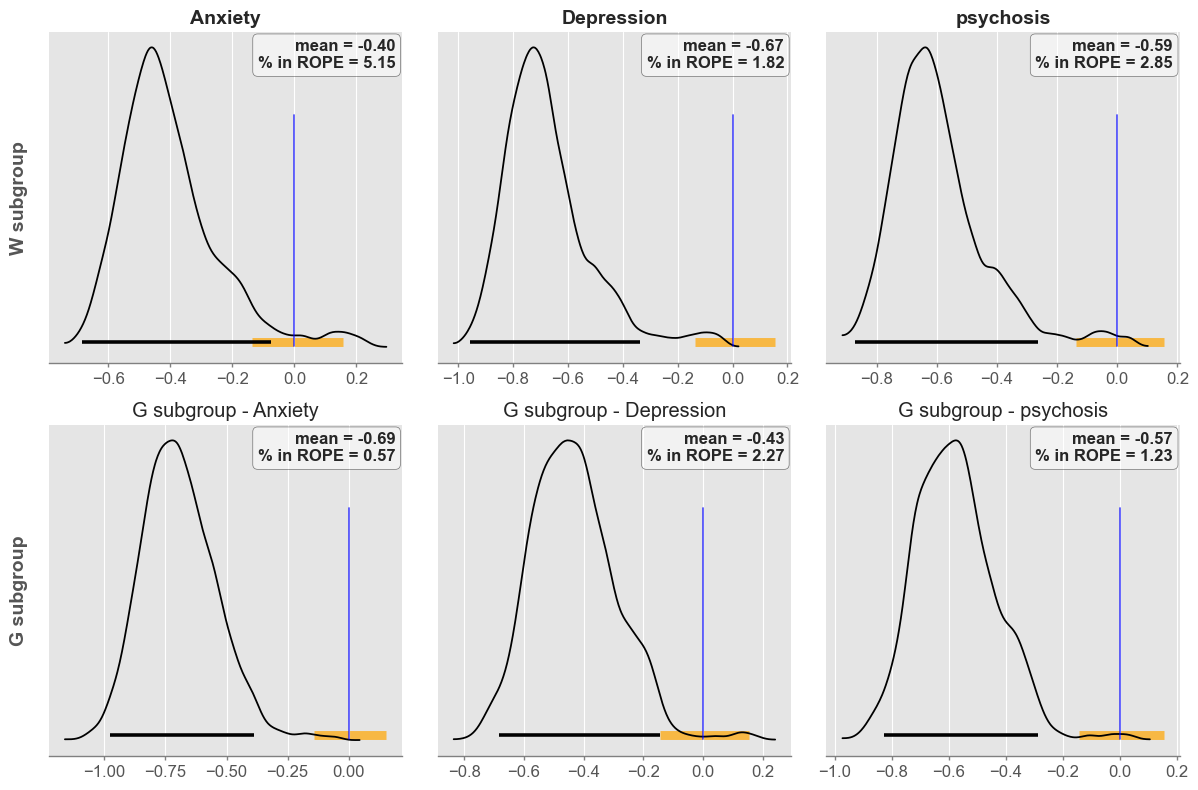

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))


groups = ["Anxiety", "Depression", "psychosis"]
datasets = [w_subjects_sum[w_meaningful], g_subjects_sum[g_meaningful]]
row_labels = ["W subgroup", "G subgroup"]

for row, dataset in enumerate(datasets):
    for col, group in enumerate(groups):
        # subset the dataset for the group

        if "W" in row_labels[row]:
            rope = w_rope
            idx_data = w_data_wide[~w_data_wide['group'].str.contains("Control")].reset_index(drop=True).iloc[w_meaningful].reset_index(drop=True)
        else:
            rope = g_rope
            idx_data = g_data_wide[~g_data_wide['group'].str.contains("Control")].reset_index(drop=True).iloc[g_meaningful].reset_index(drop=True)
        
        group_idx = idx_data.groupby("group").groups[group]
        subset = dataset[group_idx]
        # average across subjects, but keep draws
        posterior_mean = subset.mean(dim="sub")

        az.plot_posterior(
            posterior_mean,
            hdi_prob=0.95,
            rope=rope,
            ax=ax[row, col],
            textsize=12,
            color="black",
            rope_color="orange",
            ref_val_color="blue",
            ref_val=0
        )
        ax[row, col].set_title(f"{row_labels[row]} - {group}")
        for txt in list(ax[row, col].texts):
            txt.remove()

        mean_val = posterior_mean.mean().item()
        rope_pct = 100 * ((posterior_mean > rope[0]) & (posterior_mean < rope[1])).mean().item()


        # Add annotation box
        box_text = (
            f"mean = {mean_val:.2f}\n"
            f"% in ROPE = {rope_pct:.2f}"
            
        )
  
        ax[row, col].text(
            0.98,
            0.98,
            box_text,
            transform=ax[row, col].transAxes,
            ha="right",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.5,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ))
for col, group in enumerate(groups):
    ax[0, col].set_title(group, fontsize=14, fontweight="bold")


for row, label in enumerate(row_labels):
    ax[row, 0].set_ylabel(label, fontsize=14, fontweight="bold", labelpad=15)
plt.tight_layout()
plt.show()


## Obtaining behavioural differences

In [22]:
ethnicity_key ={
    "White":"white",
    "Black or African American": "non-white",
    "American Indian/Alaska Native": 'non-white',
    "Asian":  'non-white',
    "Other Non-White": 'non-white',
    "American Indian/Alaska Native": 'non-white',
    'Hawaiian or Pacific Islander': 'Hawaiian or Pacific Islander',
    'More than one race': "unknown",
    'Unknown or not reported': "unknown",

}

In [23]:
beh_data_sum = beh_data[beh_data['group'] != "Control"].reset_index(drop=True)
beh_data_sum['ethnicity'] = beh_data_sum['race'].apply(lambda x: ethnicity_key[x])
meaningful_beh = beh_data_sum.loc[w_meaningful]

In [24]:
np.round(meaningful_beh.groupby("group").size())

group
Anxiety        6
Depression    21
psychosis     13
dtype: int64

In [25]:
y = w_subjects_sum.mean(dim=['chain', 'draw'])
regression_data = pd.concat([beh_data_sum, pd.DataFrame(data={
    "zscore_means": y.data,
})], axis=1)

In [27]:
regression_data["age"] = (
    regression_data["interview_age"] - regression_data["interview_age"].mean()
) / regression_data["interview_age"].std()

In [29]:
behavioural_model = bmb.Model(
    "zscore_means ~ 1 + age + sex + ethnicity", 
    data=regression_data, 
    categorical=['sex', 'ethnicity'],
     )
behavioural_model

       Formula: zscore_means ~ 1 + age + sex + ethnicity
        Family: gaussian
          Link: mu = identity
  Observations: 396
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.056836130853899665, sigma: 1.2720099341348599)
            age ~ Normal(mu: 0.0, sigma: 0.6177525586060071)
            sex ~ Normal(mu: 0.0, sigma: 1.2431100634468082)
            ethnicity ~ Normal(mu: [0. 0. 0.], sigma: [1.490122   2.02513784 1.3164677 ])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.24678882998426904)

In [410]:
idata_behavioural = behavioural_model.fit(draws=2000, tune=2000, chains=4, cores=4, return_inferencedata=True, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zscore_means_sigma, Intercept, age, sex, ethnicity]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


In [411]:
az.summary(idata_behavioural)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.024,0.244,-0.409,0.509,0.005,0.003,2377.0,3324.0,1.0
age,0.007,0.013,-0.017,0.031,0.000,0.000,6786.0,5213.0,1.0
sex[M],-0.004,0.025,-0.048,0.046,0.000,0.000,7040.0,5260.0,1.0
ethnicity[non-white],-0.087,0.245,-0.552,0.362,0.005,0.003,2368.0,3364.0,1.0
ethnicity[unknown],-0.108,0.247,-0.587,0.338,0.005,0.003,2410.0,3387.0,1.0
ethnicity[white],-0.072,0.244,-0.560,0.360,0.005,0.003,2352.0,3559.0,1.0
zscore_means_sigma,0.249,0.009,0.232,0.265,0.000,0.000,7523.0,4982.0,1.0


## Components

This section if finding individual components that differ by group

### Mask out values 

Meaningful values are the same as previously defined. |Z| > 0.1 and log PO < -2.94

$$
\begin{gather}
\overline{\theta} > 0.1, \\[1mm]
P\big(\log(\theta) \in \text{ROPE}_{0.025}^{0.975}\big) \log 0.95 \\
\text{ROPE}^{(c)} = \big[ \text{HDI}_{2.5\%}(\overline{\theta}_{\text{HC}}^{(c)}), \; \text{HDI}_{97.5\%}(\overline{\theta}_{\text{HC}}^{(c)}) \big], 
\overline{\theta}_{\text{HC}}^{(c)} = \frac{1}{n_{\text{HC}}} \sum_{s=1}^{n_{\text{HC}}} \theta_{s}^{(c)} \quad
\text{where } c = 0, \dots, n_{\text{components}}

\end{gather}
$$

In [20]:
w_patients_only = w_scores[w_scores['group'] != "Control"]
w_global_wide_means = w_patients_only.pivot_table(
    index=["subject", "group"],
    columns="component_num", 
    values="mean",
    sort=False
).reset_index()


In [21]:
g_patients_only = g_scores[g_scores['group'] != "Control"]
g_global_wide_means = g_patients_only.pivot_table(
    index=["subject", "group"],
    columns="component_num", 
    values="mean",
    sort=False
).reset_index()

In [22]:
w_control_variation = az.summary(wm_posteriors[w_data_wide[w_data_wide['group'] == "Control"].index].mean(dim="sub"), hdi_prob=0.95).reset_index(drop=True)
g_control_variation =  az.summary(gm_posteriors[g_data_wide[g_data_wide['group'] == "Control"].index].mean(dim="sub"), hdi_prob=0.95).reset_index(drop=True)

In [31]:
w_component_df

component_num,subject,group,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,BANDA017,Anxiety,0,0,0.377,0,0,0,0,0,...,0,0,0,0,-0.011,0,0,0.307,0,0
1,BANDA021,Anxiety,0,0,-0.507,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BANDA022,Anxiety,0,0,-3.227,-0.868,0,0,0,0,...,0,0,0,0,0,-0.178,0,0,0,0
3,BANDA023,Anxiety,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.147,0,0,0
4,BANDA025,Anxiety,0,0,0.119,0,0,0,0,0,...,0,0,0,0,0,0,0.532,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,4071,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
392,4074,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
393,4075,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
394,4088,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [34]:
w_control_variation

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,-0.003,0.062,-0.131,0.110,0.001,0.001,5413.0,3803.0,1.0
1,0.032,0.059,-0.086,0.143,0.001,0.001,6273.0,3894.0,1.0
2,-0.008,0.061,-0.122,0.112,0.001,0.001,5067.0,3564.0,1.0
3,0.004,0.066,-0.126,0.134,0.001,0.001,6580.0,3737.0,1.0
4,0.024,0.060,-0.091,0.145,0.001,0.001,4720.0,3475.0,1.0
...,...,...,...,...,...,...,...,...,...
95,0.029,0.057,-0.087,0.133,0.001,0.001,5345.0,3529.0,1.0
96,0.006,0.061,-0.117,0.122,0.001,0.001,5676.0,3768.0,1.0
97,0.022,0.064,-0.104,0.143,0.001,0.001,5397.0,3849.0,1.0
98,0.023,0.061,-0.096,0.141,0.001,0.001,5863.0,3572.0,1.0


In [ ]:
def subject_meaningul_components(means_df: pd.DataFrame, posterior: xr.DataArray, controls_data: pd.DataFrame, no_comp: int) -> pd.DataFrame:
    """
    Function to get meaningful subject
    distrubtions given the a set of controls

    Parameters
    ---------- 
    means_df: pd.DataFrame
        dataframe with mean zscores 
        from the posterior sample
    posterior: xr.DataArray
        the posterior sample
    controls_data: pd.DataFrame
        Dataframe of controls
        hdi 
    no_comp: int
        number of components
    
    Returns
    -------
    component_df: pd.DataFrame
        data frame of mean value
        if the posterior sample
        is meaningul else 0
    """
    component_df = means_df[['subject', 'group']].copy(deep=True)
    for comp in range(no_comp):
        comp_posterior = posterior[comp]
        print(comp_posterior)
        comp_is_meaninfgul = get_meaningful_values(comp_posterior, means_df[["subject", comp]].rename(columns={comp: 'mean'}), 
                                               rope=(controls_data['hdi_2.5%'][comp], controls_data['hdi_97.5%'][comp]))
        component_df[comp] = comp_is_meaninfgul['z_score'].values
    return component_df


In [36]:
w_component_df = subject_meaningul_components(w_global_wide_means, wm_posteriors[w_data_wide[w_data_wide['group'] != "Control"].index], w_control_variation, 100)
g_component_df = subject_meaningul_components(g_global_wide_means, gm_posteriors[g_data_wide[g_data_wide['group'] != "Control"].index], g_control_variation, 100)

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_14339/2552841169.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  component_df[comp] = comp_is_meaninfgul['z_score'].values
/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_14339/2552841169.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  component_df[comp] = comp_is_meaninfgul['z_score'].values


In [37]:
w_component_df

component_num,subject,group,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,BANDA017,Anxiety,0,0,0.377,0,0,0,0,0,...,0,0,0,0,-0.011,0,0,0.307,0,0
1,BANDA021,Anxiety,0,0,-0.507,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BANDA022,Anxiety,0,0,-3.227,-0.868,0,0,0,0,...,0,0,0,0,0,-0.178,0,0,0,0
3,BANDA023,Anxiety,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.147,0,0,0
4,BANDA025,Anxiety,0,0,0.119,0,0,0,0,0,...,0,0,0,0,0,0,0.532,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,4071,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
392,4074,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
393,4075,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
394,4088,psychosis,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [26]:
comp_defintion = pd.read_csv(os.path.join(config("base_dir"), "component_defintion", "component_defintions.csv"))
comp_defintion = comp_defintion[~comp_defintion['IntraHemi']]
network_comp_index = comp_defintion.groupby("definition")["Components"].apply(list).reset_index().drop(9)

In [27]:
long_df = w_component_df.melt(id_vars=["subject", "group"], 
                       var_name="Components", value_name="z_score")

long_df = long_df.drop(long_df[long_df['z_score'] ==0].index)
long_df["Components"] = long_df["Components"].astype(int)


merged = long_df.merge(comp_defintion[['definition', 'Components']], on="Components")

network_df = merged.groupby(["subject", "group", "definition"])["z_score"].mean().reset_index()
subject_counts = network_df.groupby(["group", "definition"])["subject"].nunique().reset_index(name="n_subjects")
summary = (
    network_df
    .groupby(["group", "definition"])
    .agg( # proportion of nonzero subjects
        mean_value=("z_score", "mean")          # mean value across subjects
    )
    .reset_index()
)
subject_counts = (
    network_df
    .groupby(["group", "definition"])["subject"]
    .nunique()
    .reset_index(name="n_subjects")
)

summary = summary.merge(subject_counts, on=["group", "definition"])
wide_summary = summary.pivot(index="definition", columns="group", values=["mean_value", "n_subjects"])


wide_summary.columns = [f"{grp}_{metric}" for metric, grp in wide_summary.columns]
wide_summary = wide_summary.reset_index().drop(9)

wide_summary

,definition,Anxiety_mean_value,Depression_mean_value,psychosis_mean_value,Anxiety_n_subjects,Depression_n_subjects,psychosis_n_subjects
0,Auditory,-0.005262,-0.407667,NaN,21,195,107
1,Default,-0.088023,-0.153263,NaN,29,202,107
2,Dorsal Attention,0.051076,0.065253,NaN,35,201,107
3,Frontoparietal,0.0865,0.2585,NaN,14,191,107
4,Language,-0.016048,-0.005029,NaN,42,206,107
5,Limbic,-0.074545,-0.2476,NaN,11,194,107
6,Salience,-0.022245,-0.001943,NaN,36,199,107
7,Somatomotor,0.003433,0.194142,NaN,51,203,107
8,Visual,0.016317,-0.205148,NaN,30,198,107


In [245]:
long_df = g_component_df.melt(id_vars=["subject", "group"], 
                       var_name="Components", value_name="z_score")

long_df = long_df.drop(long_df[long_df['z_score'] ==0].index)
long_df["Components"] = long_df["Components"].astype(int)


merged = long_df.merge(comp_defintion[['definition', 'Components']], on="Components")

network_df = merged.groupby(["subject", "group", "definition"])["z_score"].mean().reset_index()
subject_counts = network_df.groupby(["group", "definition"])["subject"].nunique().reset_index(name="n_subjects")
summary = (
    network_df
    .groupby(["group", "definition"])
    .agg(
        mean_value=("z_score", "mean")       
    )
    .reset_index()
)
subject_counts = (
    network_df
    .groupby(["group", "definition"])["subject"]
    .nunique()
    .reset_index(name="n_subjects")
)

summary = summary.merge(subject_counts, on=["group", "definition"])
wide_summary = summary.pivot(index="definition", columns="group", values=["mean_value", "n_subjects"])


wide_summary.columns = [f"{grp}_{metric}" for metric, grp in wide_summary.columns]
wide_summary = wide_summary.reset_index().drop(9)

wide_summary

,definition,Anxiety_mean_value,Depression_mean_value,psychosis_mean_value,Anxiety_n_subjects,Depression_n_subjects,psychosis_n_subjects
0,Auditory,-0.81125,-0.842793,-0.945739,8,29,23
1,Default,-0.417765,-0.397846,-0.571976,57,161,91
2,Dorsal Attention,-0.445363,-0.802205,-1.065618,40,121,72
3,Frontoparietal,-0.179067,-0.710819,-0.988133,30,91,45
4,Language,-0.413868,-0.826548,-1.24847,34,111,66
5,Limbic,-1.201,-1.179423,-0.955903,4,26,12
6,Salience,-0.510971,-1.008177,-0.862134,43,114,71
7,Somatomotor,-0.417037,-0.815587,-0.229483,57,175,97
8,Visual,0.12495,-0.347785,-1.299054,20,65,45


In [376]:
from tabulate import tabulate

# Get numeric column positions
numeric_cols = wide_summary.select_dtypes(include='number').columns
numeric_idx = [wide_summary.columns.get_loc(c) for c in numeric_cols]

def format_row(row):
    return [f"{v:.3f}" if i in numeric_idx else v for i, v in enumerate(row)]

print(tabulate([format_row(r) for r in wide_summary.values],
               headers=wide_summary.columns,
               tablefmt='fancy_grid',
               showindex=False))


╒══════════════════╤══════════════════════╤═════════════════════════╤════════════════════════╤══════════════════════╤═════════════════════════╤════════════════════════╕
│ definition       │   Anxiety_mean_value │   Depression_mean_value │   psychosis_mean_value │   Anxiety_n_subjects │   Depression_n_subjects │   psychosis_n_subjects │
╞══════════════════╪══════════════════════╪═════════════════════════╪════════════════════════╪══════════════════════╪═════════════════════════╪════════════════════════╡
│ Auditory         │            -1.1618   │               -1.09264  │              -0.798455 │                    5 │                      18 │                     11 │
├──────────────────┼──────────────────────┼─────────────────────────┼────────────────────────┼──────────────────────┼─────────────────────────┼────────────────────────┤
│ Default          │            -0.424595 │               -0.621235 │              -0.756582 │                   59 │                     163 │            

In [400]:
long_df = g_component_df.melt(id_vars=["subject", "group"], 
                       var_name="Components", value_name="z_score")

long_df["Components"] = long_df["Components"].astype(int)


merged = long_df.merge(comp_defintion[['definition', 'Components']], on="Components")

network_df = merged.groupby(["subject", "group", "definition"])["z_score"].mean().reset_index()

In [401]:
grey_data_set = pd.merge(network_df, beh_data_sum, left_on='subject', right_on="subject").drop('group_x', axis=1).rename(columns={"group_y": "group", "definition": "network"})
grey_data_set = grey_data_set.drop(grey_data_set[grey_data_set['network'] =='no_consensus'].index)
grey_data_set['network'] = grey_data_set['network'].astype('category')
grey_data_set['group'] = grey_data_set['group'].astype('category')
grey_data_set['ethnicity'] = grey_data_set['ethnicity'].astype('category')
grey_data_set["age"] = (
    grey_data_set["interview_age"] - grey_data_set["interview_age"].mean()
) / grey_data_set["interview_age"].std()
grey_data_set['z_score'] = grey_data_set['z_score'].astype("float")

In [402]:
grey_data_set['meanginful'] = grey_data_set['z_score'].apply(lambda x: 1 if x !=0 else 0)

<Axes: ylabel='interview_age'>

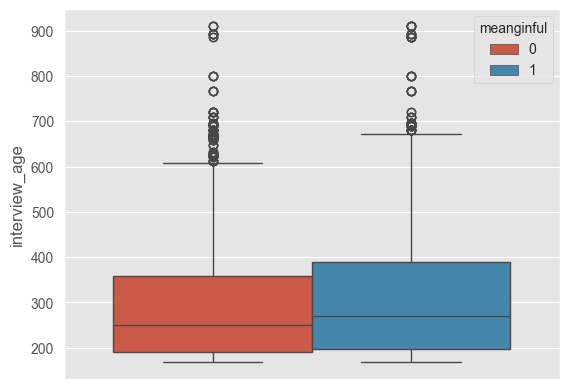

In [403]:
sns.boxplot(y='interview_age', hue=grey_data_set['meanginful'], data=grey_data_set)

In [404]:
grey_model = bmb.Model("z_score ~ group + age + ethnicity + (1 | network)", data=grey_data_set, categorical=['ethnicity', 'group'])
grey_model

       Formula: z_score ~ group + age + ethnicity + (1 | network)
        Family: gaussian
          Link: mu = identity
  Observations: 3564
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.09221868431792674, sigma: 1.4326569241358302)
            group ~ Normal(mu: [0. 0.], sigma: [1.28600835 1.44437452])
            age ~ Normal(mu: 0.0, sigma: 0.6414848149399298)
            ethnicity ~ Normal(mu: [0. 0. 0.], sigma: [1.54910824 2.10530259 1.36857986])
        
        Group-level effects
            1|network ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.4326569241358302))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.2565579254249738)

In [425]:
check = grey_model.predict(idata_grey, data=grey_data_set, inplace=False)

In [427]:
idata_grey

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [405]:
idata_grey = grey_model.fit(draws=2000, tune=2000, chains=4, cores=4, return_inferencedata=True, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_score_sigma, Intercept, group, age, ethnicity, 1|network_sigma, 1|network_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


In [406]:
az.summary(idata_grey)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.037,0.085,-0.196,0.121,0.002,0.001,2620.0,3520.0,1.00
group[Depression],0.000,0.013,-0.024,0.024,0.000,0.000,4715.0,5225.0,1.00
group[psychosis],-0.066,0.014,-0.091,-0.041,0.000,0.000,5557.0,5952.0,1.00
age,-0.039,0.005,-0.049,-0.031,0.000,0.000,5264.0,5361.0,1.00
ethnicity[non-white],-0.070,0.084,-0.223,0.089,0.002,0.001,2672.0,3655.0,1.00
ethnicity[unknown],-0.052,0.084,-0.205,0.111,0.002,0.001,2662.0,3705.0,1.00
ethnicity[white],-0.026,0.083,-0.186,0.125,0.002,0.001,2663.0,3617.0,1.00
z_score_sigma,0.249,0.003,0.244,0.255,0.000,0.000,8423.0,5912.0,1.00
1|network_sigma,0.040,0.014,0.019,0.066,0.000,0.000,2004.0,2614.0,1.01
1|network[Auditory],0.019,0.018,-0.016,0.053,0.000,0.000,2370.0,3128.0,1.00
